<a id="top"></a>
# UV Excess in Low Mass Stars
***

## Learning goals

By the end of this tutorial you will be able to:

- Understand UV excess in low mass stars
- Download data directly from URLs and handle data-frames
- Use a GUVcat catalog query and make selection cuts
- Query both SIMBAD and Vizier catalogs
- Create a color-color diagram and save it 

## Introduction

**Defining some terms used in this notebook**:
- **Color-color diagram**: diagram used to compare the apparent magnitudes of objects at different wavelengths.
- **AGB**: Asymptotic Giant Branch. This corresponds to an area of the Herzsprung-Russell diagram where evolved cool luminous stars are found, all low to intermediate mass (0.5-8 solar masses) undergo this period of stellar evolution.

**GALEX background**: <br>
The Galaxy Evolution Explorer (GALEX) was a satellite whose primary mission was to investigate the evolution of star formation, from the early universe to the present. It observed the sky in two different bands: the Near UV (NUV, 1750-2800 Å) and the Far UV (FUV, 1350-1750 Å). The GALEX database contains over 600 million source measurements in the ultraviolet domain, with some sources having more than one measurement, which could be useful to look for variability. Additionally, this survey has been used to 
detect [binary AGB stars](https://ui.adsabs.harvard.edu/abs/2008ApJ...689.1274S/abstract) and [AGB chomospheres](https://ui.adsabs.harvard.edu/abs/2017ApJ...841...33M/abstract).


## Table of Contents
* [Imports](#Imports)
* [GUVcat](#GUVcat)
    * [Via the Virtual Observatory](#Via-the-Virtual-Observatory)
* [Finding Available TWA Data](#Finding-Available-TWA-Data)
    * [In GALEX](#In-GALEX)
    * [In SIMBAD](#In-SIMBAD)
    * [Matching GUVCat to SIMBAD](#Matching-GUVCat-to-SIMBAD)
* [Getting Magntiudes of Nearby M-Dwarfs](#Getting-Magntiudes-of-Nearby-M-Dwarfs)
    * [In Vizier](#In-Vizier)
    * [In GALEX](#In-GALEX)
* [Color-Color Diagram](#Color-Color-Diagram)
* [Exercises](#Exercises)
* [Additional Resources](#Additional-Resources)

## Imports

Let's begin by importing the relevant Python libraries:
- `pyvo` to access the Virtual Observatory.
- `astropy` to handle celestial coordinates, units, and tables.
- `warnings` to manage warning messages
- `numpy` to work with arrays.
- `astroquery` to query the SIMBAD & Vizier catalogs.
- `matplotlib.pyplot` to plot the results.

In [1]:
import pyvo as vo
import astropy.units as u
import astropy.coordinates as coord
from astropy.table import Table
import warnings
warnings.simplefilter('ignore')  
import numpy as np
from astroquery.simbad import Simbad
from astroquery.vizier import Vizier
import matplotlib.pyplot as plt

## GUVcat

GUVcat can be accessed via multiple places including [this website](http://dolomiti.pha.jhu.edu/uvsky/#GUVcat), through [MAST casjobs](http://mastweb.stsci.edu/gcasjobs), or from the [SIMBAD VizieR Database](https://vizier.cds.unistra.fr/viz-bin/VizieR). Even though in this tutorial we will use a different approach, the reader is encouraged to try and download the data directly from the [GALEX catalogs of unique UV sources](http://dolomiti.pha.jhu.edu/uvsky/GUVcat/GUVcat_AIS.html) and compare. 

In the first website proposed the catalog is divided each 5º of galactic latitude, and is presented as _.csv_ files, with a naming convention such as: _GUVcat_AIS_FOV055_glat25_00N__30_00N_. This naming convention for GUVcat is as follows:
- _AIS_ corresponds to the name of the catalog, _All-sky Imaging Survey_.
- _FOV055_ refers to the 1.1 degree diameter of GALEX field-of-view. 
- _glat25_00N_30_00N_ is the lower and upper Galactic boundaries for this slice. _N_ to indicate the degrees are positive, and negative degrees are indicated with _S_.

More information about the naming convention can be found in the <a href="https://archive.stsci.edu/hlsps/guvcat/hlsp_guvcat_galex_imaging_all_fuv-nuv_v1_readme.txt">GCat README file</a>.

### Via the Virtual Observatory

The way in which we will access the GUVCat is through the virtual observatory. If you have never used the virtual observatory before please refer to David Rodriguez's <a href="https://gist.github.com/dr-rodriguez/32aa944706beee299360aa700b375baa">virtual observatory python (pyVO) tutorial.</a> <br>

As explained in the tutorial, in order to access the GUVCat catalog via the VO we need to provide the coordinates of the target we want (ra, dec), as in the example shown below for TWA 1:

In [2]:
pos = coord.SkyCoord(ra=165.4662722021100, dec=-34.7047314495500, unit='deg',frame='icrs')
size = u.Quantity(10, unit="arcsec")
scs_service = vo.dal.SCSService('http://gsss.stsci.edu/webservices/vo/ConeSearch.aspx?CAT=GALEX&')
scs_results = scs_service.search(pos=pos, radius=size)
scs_results.to_table()

objID,IAUname,RA,DEC,e_bv,nuv_artifact,fuv_artifact,nuv_flags,fuv_flags,nuv_flux,fuv_flux,nuv_fluxerr,fuv_fluxerr,nuv_fwhm_world,fuv_fwhm_world,nuv_mag,fuv_mag,nuv_magerr,fuv_magerr,nuv_fcat_flux,fuv_ncat_flux,nuv_fcat_fluxerr,fuv_ncat_fluxerr,nuv_weight,fuv_weight,survey,url,mag,distance
,,deg,deg,mag,,,,,,,,,,,mag,mag,mag,mag,,,,,,,,,mag,arcsec
int64,object,float64,float64,float32,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,object,object,float32,float32
6386924702772757883,GALEX J110151.7-344217,165.465776054982,-34.7047816865525,0.06994488,0,0,0,0,6569.914,2549.284,53.16022,51.13747,0.002040816,0.001510264,14.3561,15.38396,0.008787328,0.02178466,6244.068,2630.659,45.69708,60.6461,79.51563,94.64063,AIS,"<a href=""http://galex.stsci.edu/GR6/?page=explore&photo=true&objid=6386924702772757883"" target=""_blank"">6386924702772757883</a>",14.3561,0.024657784


Let's display the different column names that the catalog provides:

In [3]:
print(scs_results.to_table().columns)

<TableColumns names=('objID','IAUname','RA','DEC','e_bv','nuv_artifact','fuv_artifact','nuv_flags','fuv_flags','nuv_flux','fuv_flux','nuv_fluxerr','fuv_fluxerr','nuv_fwhm_world','fuv_fwhm_world','nuv_mag','fuv_mag','nuv_magerr','fuv_magerr','nuv_fcat_flux','fuv_ncat_flux','nuv_fcat_fluxerr','fuv_ncat_fluxerr','nuv_weight','fuv_weight','survey','url','mag','distance')>


Some relevant identifiers are:

- _objID_: GALEX identifier for the source.
- _RA_: source’s Right Ascension (degrees).
- _DEC_: source’s Declination (degrees).
- _fuv/nuv_mag_: FUV/NUV calibrated magnitude.
- _fuv/nuv_flux_: FUV/NUV calibrated flux (micro Jansky).

Let's take a look now at how to access a specific value inside a table. In order to do this, we need to provide the name of the column we want to access, for example for the NUV magnitude:

In [4]:
print(scs_results['nuv_mag'])

[14.356100082397461]


## Finding Available TWA Data

### In GALEX

Since we want to create a color-color comparison using the GALEX catalog, we can select a sample of young, low-mass stars such as the TW Hydrae Association. The coordinates of its members extracted from SIMBAD have been provided in a _.txt_ file along with this tutorial; the first column corresponds to the name of the star, the second to its right ascension and the third to its declination (both in degrees).

The first step for this process will be then to load this information using the _numpy_ function _loadtxt_. If we use the option _unpack=True_ we can directly separate the three columns into different arrays to better handle them later. Additionally, _loadtxt_ assumes float as the standard input, so since the first column will correspond to strings, let's use the parameter _dtype_ to specify that the first column has a string (U) format and the next two are floats (f). 

In [5]:
names_TWA, ra_TWA, dec_TWA = np.loadtxt('TWA_coordinates_complete.txt', unpack = True, dtype="U7,f8,f8")

In [6]:
print('Name of the stars in the TWA: ', names_TWA)

Name of the stars in the TWA:  ['TWA_2' 'TWA_3' 'TWA_4' 'TWA_5' 'TWA_6' 'TWA_7' 'TWA_8A' 'TWA_8B'
 'TWA_9A' 'TWA_9B' 'TWA_10' 'TWA_11A' 'TWA_11B' 'TWA_11C' 'TWA_12'
 'TWA_13A' 'TWA_13B' 'TWA_14' 'TWA_15A' 'TWA_15B' 'TWA_16' 'TWA_17'
 'TWA_18' 'TWA_19A' 'TWA_19B' 'TWA_20' 'TWA_21' 'TWA_22' 'TWA_23' 'TWA_24'
 'TWA_25' 'TWA_26' 'TWA_27' 'TWA_28' 'TWA_29' 'TWA_30' 'TWA_30B' 'TWA_31'
 'TWA_32' 'TWA_33' 'TWA_34']


In [7]:
print('Right Ascension of the stars in the TWA [deg]: ', ra_TWA)

Right Ascension of the stars in the TWA [deg]:  [167.30747036 167.6162253  170.52204061 172.98025373 154.61957813
 160.62542455 173.17194118 173.17155553 177.10092809 177.09889501
 188.76773349 189.00429894 189.00228808 188.95391504 170.27283924
 170.32174722 170.32267942 168.35925362 188.58603391 188.58530003
 188.7345942  200.18911553 200.40508013 176.85226592 176.83580497
 187.90862149 153.31155192 154.36205323 181.86406831 182.42441209
 183.87800133 174.96307432 181.88944814 165.54099116 191.30900324
 173.07629827 173.07591241 181.79536803 186.7140274  174.89093731
 157.19083017]


In [8]:
print('Declination of the stars in the TWA [deg]: ', dec_TWA)

Declination of the stars in the TWA [deg]:  [-30.02776913 -37.5311017  -24.77771031 -34.60755664 -31.83411946
 -33.67117495 -26.86554497 -26.8691966  -37.48030952 -37.48014456
 -41.61072667 -39.86950568 -39.87102599 -39.84015754 -38.7545897
 -34.77930646 -34.78049328 -45.39520027 -48.25375871 -48.25542933
 -45.6354537  -46.19380874 -44.36440603 -49.8841718  -49.88453792
 -45.98318276 -52.51500042 -53.90732984 -32.78340081 -58.91251712
 -39.81183519 -31.98928991 -39.54833795 -34.50987839 -44.48548007
 -30.3310716  -30.3087898  -32.51493218 -33.2701509  -30.66676829
 -28.51042382]


So, once we have all the coordiantes for the stars in TWA, let's look them up via VO, and flag those who do not show up in GALEX:

In [9]:
n = len(names_TWA)
nuv_TWA = np.zeros(n)
not_GALEX = []

print('Not in GALEX: ',end='')
for i in range(n):
    pos = coord.SkyCoord(ra=ra_TWA[i], dec=dec_TWA[i], unit='deg',frame='icrs')
    size = u.Quantity(10, unit="arcsec")
    scs_service = vo.dal.SCSService('http://gsss.stsci.edu/webservices/vo/ConeSearch.aspx?CAT=GALEX&')
    scs_results = scs_service.search(pos=pos, radius=size)
    if (len(scs_results['nuv_mag']) > 0):
        nuv_TWA[i] = float(scs_results['nuv_mag'][0])
    else:
        not_GALEX.append(names_TWA[i])
        
print(not_GALEX)

Not in GALEX: ['TWA_7', 'TWA_8B', 'TWA_11A', 'TWA_11B', 'TWA_11C', 'TWA_15A', 'TWA_15B', 'TWA_19A', 'TWA_19B', 'TWA_21', 'TWA_24', 'TWA_26', 'TWA_27', 'TWA_29', 'TWA_30B']


Some of the stars are not in GUVCat, but we still have enough sample stars to create the color-color diagram that we want.

### In SIMBAD

To create the color-color diagram we need additional bands to perform the comparison. In order to do so, we can use some of the bands provided by the SIMBAD catalog ($K - 2.159 \mu m, V - 0.540 \mu m$). In order to do that, we should add the votable fields 'flux(K)' and 'flux(V)' to the Simbad query with the following command:

In [10]:
Simbad.add_votable_fields('flux(K)','flux(V)')

Even though the votable field that we have added says 'flux', this will provide us with the magnitude in those band, let's check it for our first star, 'TWA 1':

In [11]:
table_twa2 = Simbad.query_object('TWA 2')

table_twa2

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,FLUX_K,FLUX_V,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,mag,mag,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,float32,float32,int32
CD-29 8887,11 09 13.7928,-30 01 39.968,14,14,0.148,0.152,90,A,O,2020yCat.1350....0G,6.71,11.119,1


As you can see, below the name 'FLUX_K' it indicates it is a magnitude! So now let's do it for the whole TWA using the _names_TWA_ array. 

_**Note**: some elements may not have the Vmagnitude, such as 'TWA 11B', which is displayed below for the reader to see the problematic values._

In [12]:
table_twa31 = Simbad.query_object('TWA 31')

table_twa31

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,FLUX_K,FLUX_V,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,mag,mag,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,float32,float32,int32
TWA 31,12 07 10.8883,-32 30 53.755,14,14,0.038,0.028,90,A,O,2020yCat.1350....0G,12.115,--,1


These elements will appear as NaN when converted to float numbers. A way to check if a value is NaN in Python is to check if it is not equal to itself, we will use this to flag the missing values.

In [13]:
n = len(names_TWA)
magK_TWA = []
magV_TWA = []
missing_val_i = []
missing_V = []

print('Missing V-band magnitude: ',end='')
for i in range(n):
    table = Simbad.query_object(names_TWA[i])
    if (float(table['FLUX_V']) != float(table['FLUX_V'])):
        missing_V.append(names_TWA[i])
        missing_val_i.append(i)
        magK_TWA.append(float(table['FLUX_K']))
        magV_TWA.append(0)
        continue
    else:
        magK_TWA.append(float(table['FLUX_K']))
        magV_TWA.append(float(table['FLUX_V']))
        
print(missing_V)

Missing V-band magnitude: ['TWA_11B', 'TWA_26', 'TWA_29', 'TWA_30', 'TWA_30B', 'TWA_31', 'TWA_34']


After removing the missing values, we are still left with 42 stars, this can be checked by looking at the length of the _magK_TWA_ and _magV_TWA_ lists:

In [14]:
print(len(magK_TWA))

41


We will convert now the lists we created to numpy arrays in order to better handle them. 

In [15]:
magK_TWA = np.array(magK_TWA)
magV_TWA = np.array(magV_TWA)

### Matching GUVCat to SIMBAD

Since some values were missing for both the NUV and the V band magnitudes, we need to perform a match between GUVcat and SIMBAD to only keep those stars that have both measurements.

In [16]:
matched_i = []

for i in range(len(names_TWA)):
    if (nuv_TWA[i] != 0.) & (i not in missing_val_i):
        matched_i.append(i)
        
print(matched_i)

[0, 1, 2, 3, 4, 6, 8, 9, 10, 14, 15, 16, 17, 20, 21, 22, 25, 27, 28, 30, 33, 38, 39]


## Getting Magntiudes of Nearby M-Dwarfs

### In VizieR

We will use the sample proposed by <a href="https://ui.adsabs.harvard.edu/abs/2021AJ....161...63W/abstract">Winters et al. 2021</a> of nearby M-dwards to compare it with the TWA (young stellar association) in the color-color diagram. This sample can be accesed via the VizieR catalog. In order for VizieR to load the full catalog, let's first change the row limit to -1 in order to avoid the default row limit of 50.

In [17]:
Vizier.ROW_LIMIT = -1

Now that we have changed the row limit, let's access the catalog that we want, the catalog name for this sample is 'J/AJ/161/63/table3'. Let's look it up using the _get_catalogs_ method:

In [19]:
catalogs = Vizier.get_catalogs("J/AJ/161/63/table3")

winters2021 = catalogs[0]

From this table, we can directly get the name of the star, the V and K magnitudes, the right ascension and the declination for each star. 

_**Note**: some stars may be missing the V magnitude, we must flag these stars and not use them for the final color-color diagram._

In [20]:
name_w21 = []
V_w21 = []
K_w21 = []
ra_w21 = []
dec_w21 = []
missing_V = []

print('Missing V-band magnitude: ',end='')
for i in range(len(winters2021)):
    if str(winters2021[i]['Vmag'])!='--' and str(winters2021[i]['Kmag'])!='--':
        name_w21.append(winters2021[i]['Name'])
        V_w21.append(float(winters2021[i]['Vmag']))
        K_w21.append(float(winters2021[i]['Kmag']))
        ra_w21.append(winters2021[i]['RAJ2000'])
        dec_w21.append(winters2021[i]['DEJ2000'])
    elif str(winters2021[i]['Vmag'])=='--':
        missing_V.append(winters2021[i]['Name'])

name_w21 = np.array(name_w21)
V_w21 = np.array(V_w21)
K_w21 = np.array(K_w21)
ra_w21 = np.array(ra_w21)
dec_w21 = np.array(dec_w21)

print(missing_V)

Missing V-band magnitude: ['LP 191-43', 'GJ 1005', 'G 172-1', 'G 172-1', 'L 291-115', '2MA 0049+6518', 'LTT 10301', 'LSPM 0058+3919', 'G 218-20', 'GJ 1029', 'GJ 53', 'GJ 1031', 'LTT 10491', 'GJ 61', 'GJ 65', 'GJ 67', 'LP 30-55', 'LSPM 0202+1034', 'LSPM 0202+1034', '2MA 0213+3648', 'G 36-26', 'LP 993-116', 'LP 831-1', 'LTT 1445', 'LHS 1516', 'LP 357-56', 'LSPM 0357+4107', '2MA 0406-0534', 'LHS 1629', 'LHS 1681', 'LTT 11472', 'LSPM 0501+2237', 'UPM 0505+4414', '2MA 0505-4756', 'LTT 11586', 'G 86-28', 'LP 119-26', 'L 449-1', 'LEHPM 2-1009', 'LHS 5108', 'SCR 0533-4257', 'LSPM 0536+1117', 'GJ 1083', 'GJ 222', 'LSPM 0556+1144', 'GJ 231', 'GJ 228', 'LP 779-34', 'LSPM 0617+8353', 'L 308-57', 'GJ 233', 'GJ 234', 'SCR 0630-7643', '2MA 0635-0403', '2MA 0635-0403', 'LHS 221', 'GJ 257', 'LHS 1885', 'LHS 224', 'GJ 268', 'LHS 1901', 'LHS 1901', 'LHS 1918', 'LTT 17993', 'LSPM 0747+5020', 'LHS 1955', 'UPM 0815-2344', 'LHS 2004', 'LHS 2010', 'GJ 310', 'LSPM 0840+3127', 'GJ 324', 'G 41-8', 'GJ 1116', 'LT

### In GALEX

Since we have the coordinates for each star, we can use this to look up the desired targets in GALEX and retrieve their NUV magnitude now. However, the format that GALEX accepts is in the form HHhMMmSSss DDdMMmSSs and we have our coordinates in the HH MM SS DD MM SS format, so we must fix this before making the query. This can be fone by using the <a href="https://docs.python.org/3/library/stdtypes.html">_split()_</a> method for strings as show below:

In [21]:
print('Coordinates before: RA - ',ra_w21[0],' DEC -',dec_w21[0])
ra = ra_w21[0].split()
dec = dec_w21[0].split()
print('Coordinates before: RA - ',ra[0]+'h'+ra[1]+'m'+ra[2]+'s',' DEC -',dec[0]+'d'+dec[1]+'m'+dec[2]+'s')

Coordinates before: RA -  00 04 36.46  DEC - -40 44 02.7
Coordinates before: RA -  00h04m36.46s  DEC - -40d44m02.7s


Now, let's use this to perform our query!

_**Note**: again, some stars may not have a NUV magnitude, we should flag them and remove them from our sample for the color-color diagram_

In [22]:
nuv_w21 = []
keep_i_w21 = []
missing_NUV = []

print('Missing NUV magnitude: ',end='')
for i in range(len(ra_w21)):
    ra1 = ra_w21[i].split()
    dec1 = dec_w21[i].split()
    pos = coord.SkyCoord(ra=ra1[0]+'h'+ra1[1]+'m'+ra1[2]+'s', dec=dec1[0]+'d'+dec1[1]+'m'+dec1[2]+'s',frame='fk5')
    size = u.Quantity(10, unit="arcsec")
    scs_service = vo.dal.SCSService('http://gsss.stsci.edu/webservices/vo/ConeSearch.aspx?CAT=GALEX&')
    scs_results = scs_service.search(pos=pos, radius=size)
    if str(scs_results['nuv_mag'])!='[]' and scs_results['nuv_mag'][0]!=-999.0:
        keep_i_w21.append(i)
        nuv_w21.append(float(scs_results['nuv_mag'][0]))
    else:
        missing_NUV.append(name_w21[i])
    
nuv_w21 = np.array(nuv_w21)

print(missing_NUV)

Missing NUV magnitude: ['GJ 1002', 'LSPM 0011+5908', 'GJ 12', 'GJ 15', 'LHS 112', 'GJ 1013', 'GJ 1014', 'LHS 1140', 'GJ 1025', 'GJ 1028', 'GJ 1029', 'GJ 1035', 'GJ 65', 'LP 991-84', 'LHS 5045', 'GJ 83.1', 'LHS 1326', 'LHS 1339', 'GJ 105', 'GJ 1050', 'SCR 0246-7024', 'LHS 1443', 'LHS 1490', 'GJ 1055', 'GJ 1053', 'GJ 1057', 'GJ 1059', 'LSPM 0330+5413', 'LHS 176', 'GJ 1061', 'LSPM 0336+3118', 'L 228-92', 'LHS 1593', 'GJ 1068', 'LHS 1638', 'GJ 164', 'GJ 166', 'G 7-34', 'LHS 1668', 'GJ 170', 'LHS 1690', 'GJ 1072', 'LHS 1723', 'LTT 11586', 'GJ 203', 'GJ 213', 'GJ 2045', 'G 99-49', 'LHS 1805', 'LHS 1809', 'AP COL', 'GJ 1088', 'G 192-22', 'GJ 232', 'GJ 234', 'SCR 0642-6707', 'GJ 1092', 'GJ 257', 'LHS 224', 'G 107-48', 'SCR 0717-0501', 'L 136-37', 'LHS 1918', 'GJ 275.2', 'SCR 0736-3024', 'GJ 283', 'SCR 0754-3809', 'LTT 12102', 'GJ 299', 'LHS 1993', 'UPM 0815-2344', 'LHS 2005', 'LHS 246', 'SCR 0838-5855', 'LHS 252', 'LHS 2090', 'SCR 0914-4134', 'GJ 1123', 'LP 788-1', 'GJ 359', 'GJ 1128', 'LHS 51

## Color-Color Diagram

Let's now create the color-color diagram and compare the young stars to the M-dwarfs sample. In order to save this image to our local directory, we can use _plt.savefig_, we need to provide the filename we want for our file, and whether we want to save it as _.jpg_, _.png_, _.pdf_, etc. Let's do this example with the filename _colorcolor.jpg_.

_**Note**: if you wanted to save the image in a different directory from the current one, you could do so by simply providing the path as the filename in plt.savefig, such as: plt.savefig('../Documents/UV_excess_tutorial/colorcolor.jpg')._

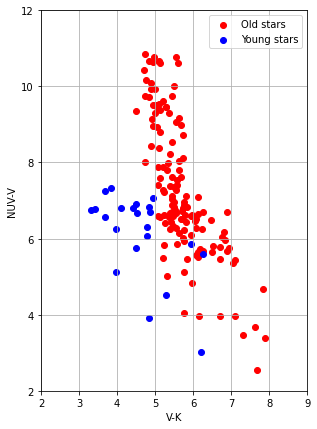

In [23]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
plt.scatter(V_w21[keep_i_w21]-K_w21[keep_i_w21],nuv_w21-V_w21[keep_i_w21],c='r',label='Old stars')
plt.scatter(magV_TWA[matched_i]-magK_TWA[matched_i],nuv_TWA[matched_i]-magV_TWA[matched_i],c='b',label='Young stars')
ax.set_aspect('equal')
plt.ylabel('NUV-V')
plt.xlabel('V-K')
plt.xlim([2,9])
plt.ylim([2,12])
plt.legend(loc='best')
plt.grid()
plt.savefig('colorcolor.jpg')
plt.show()

In this diagram it can be seen that, for the same $V-K$ colors, young stars tend to be below the older stars, i.e. to have lower values of $NUV-V$. What this means is that the same type of stars produces more NUV light when it is in its earlier stages. For more information related to this topic, please refer to <a href="https://ui.adsabs.harvard.edu/abs/2011ApJ...727...62R/abstract">Rodriguez et al. 2011</a> and <a href="https://ui.adsabs.harvard.edu/abs/2013ApJ...774..101R/abstract">Rodriguez et al. 2013</a>.

## Exercises

Now try to re-create the steps we followed in this tutorial for the TW Hya star, from which the TW Hydrae association gets its name. The ICRS coordinates (ep = J2000) of TW Hya are, according to SIMBAD:

- RA: 165.4662722021100 deg
- DEC: -34.7047314495500 deg

### 1. GALEX query

Use the coordinates of TW Hya to find the NUV magnitude in GALEX for the source, as we did before.

In [ ]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
# You can also use any function that was defined before


### 2. SIMBAD query

Now, using either the name or the coordinates of the source, look it up in SIMBAD database and retrieve its K and V magnitudes.

In [ ]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
# You can also use any function that was defined before


### 3. Include TW Hya in color-color diagram

Finally, include in the color-color diagram that we created before, make sure to use a different marker and/or color to differentiate it from the rest of the sources!

In [ ]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
# You can also use any function that was defined before


TW Hya has a substantial NUV excess, in particular in the $NUV-J$ color, with a $NUV-J \sim 6$ while the rests of the stars in the association have a value around $\sim 9-11$. An additional emission source is required to explain this excess, apart from the youth of all these stars. The most probable theory is continuous accretion onto the star, in addition to the disk being face on, causing the accretion to be unobscured. For more information about this topic, please refer to <a href="https://ui.adsabs.harvard.edu/abs/2011ApJ...727...62R/abstract">Rodriguez et al. 2011.</a>

## Additional Resources

* [GALEX Mission Overview](https://asd.gsfc.nasa.gov/archive/galex/Documents/MissionOverview.html)
* <a href="https://mast.stsci.edu/api/v0/index.html">MAST API</a> 
* [GALEX UV Unique Source Catalog](https://archive.stsci.edu/hlsp/guvcat)
* <a href="https://pyvo.readthedocs.io/en/latest/index.html">PyVO documentation</a> <br> 

## About this Notebook

**Author**: Clara Puerto Sánchez <br>
**Keyword(s)**: Tutorial, UV excess, M-dwarfs <br>
**Last Updated**: Aug 2022 <br>
**Next review**: Mar 2023

For support, please contact the Archive HelpDesk at archive@stsci.edu.
***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>